# KHARMA Tutorial 
# CCA Numerical Series on Fluids and Plasmas (10/24/2024)
---
---

## Getting KHARMA

KHARMA can be found on Github [here](https://github.com/AFD-Illinois/kharma).
For this tutorial we'll be working with the `tutorial` branch which can be cloned like,

`git clone -b tutorial https://github.com/AFD-Illinois/kharma.git`

---

## Building pyharm

Additionally, we'll need `pyharm`, a Python package for analyzing GRMHD data products from HARM-based codes. The code is hosted [here](https://github.com/AFD-Illinois/pyharm), and can be obtained using git,

`git clone https://github.com/AFD-Illinois/pyharm.git`

It's generally good practice to isolate Python environments when working on different projects to avoid dependency hell. Also, the SCC at FI won't let us install python packages on the Python moduel provided by them. Let's download the python module (if you don't have it by default in your module stack), set up a virtual environment, and install `pyharm`,

```
module load python3
VENVDIR=PATH_WHERE_PYTHON_VENVS_ARE_STORED
python3 -m venv --system-site-packages $VENVDIR/pyharm
source $VENVDIR/pyharm/bin/activate
cd pyharm
pip3 install -e .
```
where, `VENVDIR` is the location where you would want to save your Python environments; for this tutorial we've created a virtual enviroment `pyharm`. More about Python virtual environments on Rusty [here](https://wiki.flatironinstitute.org/SCC/Software/PythonVirtualEnvironments). 

If you instead prefer working with `conda`, `pyharm` has a `environment.yml` file that can be used to set up an environment with `conda`. More about that [here](https://pyharm.readthedocs.io/en/latest/installing.html).

---

## Building KHARMA

KHARMA has two main dependencies which must be checked out before compiling it,
```
cd kharma
git submodule update --init --recursive
```

KHARMA has an extensive [wiki](https://github.com/AFD-Illinois/kharma/wiki) and lists the minimum requirements needed. Let us set up the module environment needed to compile KHARMA for GPUs on Rusty,

```
module load modules/2.3-20240529 slurm cmake gcc/11.4.0 cuda gsl openmpi hdf5 openblas
```
For CPUs, it's nearly the same, except we don't need the `cuda` module. 

KHARMA uses `cmake` to build the code called from the `make` shell script. This script in conjuction with machine-specific build files are help set up the module environment and pass necessary arguments to `cmake`. By default KHARMA parallelizes the build process, and therefore it is good practice to compile KHARMA on a compute node. To get an interactive session on a compute node on Rusty try,

`srun -N 1 --constraint=ib-icelake --pty bash -i`

To run KHARMA on NVIDIA A100s use the following command,

`./make.sh clean cuda a100`

The `cuda` argument tells Kokkos to build with CUDA, while the `a100` argument specifies the device architecture. KHARMA's build philosophy is to have separate machine-specific files that setup the relevant module environment and environment variables, e.g., there is a machine config file for Rusty (`machines/rusty.sh`) that builds for different architectures available on Rusty.

If you'd like to build for KHARMA to be run on CPU, say the icelake nodes, the build command would be,

`./make.sh clean skx`.

At the end, you should see the following output on the screen that comfirms KHARMA was built successfully,

![gpu build](images/screenshot_gpu_build.png)

OR

![cpu build](images/screenshot_cpu_build.png)

depending on the type of build. The postfix (`.cuda`, `.host`) in the executable name specifies the architecture KHARMA was built for. More about compiling [here](https://github.com/AFD-Illinois/kharma/wiki/Building-KHARMA).

---

## Running KHARMA

KHARMA can either be run in broadly two ways,
- By directly calliing the executable: `./kharma.host -i PROBLEM_PARAMETER_FILE`. This works best when you are running on a personal computer or are on a compute node via an interactive job, and have manually set the module stack and required environment variables correctly.

- Invoking `run.sh` or a batch script: Often, we don't want to manually set the environment and want the runtime environment to be set automatically based on the compile-time options. This is where `run.sh` or a machine-specific batch script comes in.

For this tutorial we'll use the slurm batch scripts located in the `scripts/tutorial/batch` directory. This script sets the SLURM directives, sources the machine file to set the module environment, and submits the job.

### Problem 1: Pressure equilibrium in ideal MHD

It is good practice to create a separate directory for each problem run; say `SIMULATION_DIR` is where we'll run the first problem. KHARMA will output data to the directory where the executable is called from. Let's run the following set of commands,

```
cd SIMULATION_DIR
cp PATH_TO_KHARMA_SOURCE/scripts/tutorial/batch/rusty_gpu.sb ./
cp PATH_TO_KHARMA_SOURCE/scripts/tutorial/parfiles/anisotropic_conduction_ideal.par ./
```
This copies over the job submit script and the parameter file for the problem to `SIMULAITON_DIR`. Before we move on to running the problem, let's take a look at the parameter file.

KHARMA was designed from ground up with flexibility and extensibility in mind; most parameters are therefore runtime. This means the number of parameters is [long and growing](https://github.com/AFD-Illinois/kharma/wiki/Parameters). However, on a day-to-day basis there are only a limited number of parameters that you'd need to modify depending on the problem and KHARMA sets sensible default values for the rest.
Parameters are divided into blocks and are specified like `block_name/parameter_name=value`. Let's take a look at the parameter file for this problem to see this in practice.

Now, let's submit the job

`sbatch rusty_gpu.sb -i anisotropic_conduction_ideal.par`

In this case we explicitly ask Parthenon (via the `-d` flag in the job submit script) to create the save output (dump files, restart files, etc..) in a separate directory `dumps_kharma`. We could have pointed to the parameter file at `PATH_TO_KHARMA_SOURCE/scripts/tutorial/parfiles/` but it is cleaner this way---each simulation has its own copy of the parameter file and we avoid changing the defaults in the git repository.

**Congratulations on running your first KHARMA simulation!**

Let's take a look at the output. The standard output is saved to the `.out` file. When the problem is executing, you'll see a line like this (for explicitly-evolved problems at least),

```
cycle=50 time=6.0457029249727713e-02 dt=1.4976930529853696e-03 zone-cycles/wsec_step=4.24e+07 wsec_total=4.25e-01 wsec_step=6.18e-03
Max DivB: 1.52656e-16
```
`cycle` denotes the timestep number, `time` is the simulation time in code units (e.g., for a black hole accretion problem it'd be in units of the light-crossing time $GM/c^3$), `dt` is the size of the timestep, and `zone-cycles/wsec_step` is the number of zone cycle per second.

The simulation output is saved to `dump_kharma`. Files ending with `phdf` are the fluid "dump" files and stores the state of the fluid at a given time. Restart files have the `rhdf` extensions.

It is most convenient to use `pyharm` to work with KHARMA output. At the heart of `pyharm` is the FluidDump object that caches the data in the dump file, and computes derived quantities from the cached data on-the-fly. It acts like a Python dictionary from which various quantities (related to the fluid state, grid, input parameters, etc..) can be accessed by passing the right key. The `load_dump` method is used to obtain the fluid state object. For example,

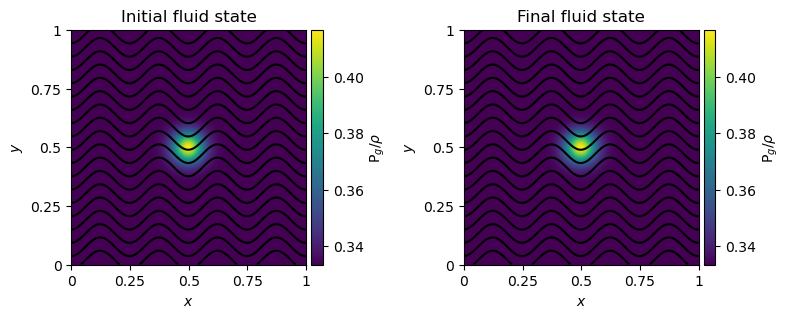

In [3]:
import pyharm
import matplotlib
import numpy as np
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

# Function to overlay field lines
# Argument must be axes object, dump, and 'nlines' -> a parameter to account for density of field lines
def plotting_bfield_lines(ax, dump, nlines=20):
  B1 = np.squeeze(dump['B1'])
  B2 = np.squeeze(dump['B2'])
  AJ_phi = np.zeros([dump['n1'], dump['n2']])
  for j in range(dump['n2']):
    for i in range(dump['n1']):
      AJ_phi[dump['n1']-1-i,j] = (np.trapz(B2[:i,j], dx=dump['dx1']) - np.trapz(B1[i,:j], dx=dump['dx2']))
  AJ_phi -= AJ_phi.min()
  levels  = np.linspace(0, AJ_phi.max(), nlines)
  ax.contour(np.squeeze(dump['X1']), np.squeeze(dump['X2']), AJ_phi, levels=levels, colors='k')

# Create figure object and grid
fig = plt.figure(figsize=(8,4))
nrows = 1
ncols = 2
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# Load first dump and plot
dump = pyharm.load_dump('') # insert path to first dump
temperature_plot = ax0.pcolormesh(np.squeeze(dump['X1']), np.squeeze(dump['X2']), np.squeeze(dump['Theta']), cmap = 'viridis', shading='gouraud')
plotting_bfield_lines(ax0, dump, nlines=20)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.set_xticks([0,0.25,0.5,0.75,1])
ax0.set_xticklabels([0,0.25,0.5,0.75,1])
ax0.set_yticks([0,0.25,0.5,0.75,1])
ax0.set_yticklabels([0,0.25,0.5,0.75,1])
ax0.set_xlabel('$x$')
ax0.set_ylabel('$y$')
ax0.set_title('Initial fluid state')
ax0.set_aspect('equal')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(temperature_plot, cax=cax)
cbar.set_label('P$_{g}/\\rho$', rotation=90)

# Load final dump and plot
dump = pyharm.load_dump('') # insert path to final dump
temperature_plot = ax1.pcolormesh(np.squeeze(dump['X1']), np.squeeze(dump['X2']), np.squeeze(dump['Theta']), cmap = 'viridis', shading='gouraud')
plotting_bfield_lines(ax1, dump, nlines=20)
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xticks([0,0.25,0.5,0.75,1])
ax1.set_xticklabels([0,0.25,0.5,0.75,1])
ax1.set_yticks([0,0.25,0.5,0.75,1])
ax1.set_yticklabels([0,0.25,0.5,0.75,1])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Final fluid state')
ax1.set_aspect('equal')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(temperature_plot, cax=cax)
cbar.set_label('P$_{g}/\\rho$', rotation=90)

plt.tight_layout()
plt.show()

If you'd like to plot all the dumps and make a movie of the simulation, copy over the script `PATH_TO_KHARMA_SOURCE/scripts/tutorial/analysis/plot_anisotropic_conduction.py` to `SIMULATION_DIR` and run it (NOTE: By default the script parallelizes the plotting, so best to run it over a compute node). You can then download the `ffmpeg` module and make a movie using `ffmpeg -r 24 -start_number 0 -pattern_type glob -i ./plots/\*.png -vcodec libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -crf 24 -pix_fmt yuv420p ./anisotropic_conduction_emhd.mp4`.

Since the initial configuration is in pressure equilibrium, it is a time-independent solution to the equations of ideal MHD.

### Problem 2: Pressure equilibrium in Extended MHD

The ``Extended'' MHD model is meant to incorporate low-collisionallity effects in plasmas ([Chandra et al.](https://ui.adsabs.harvard.edu/abs/2015ApJ...810..162C/abstract)). The model introduces two new variables---heat flux $q$ and pressure anisotropy (or equivalently, a shear viscosity) $\Delta P$---that representes dissipative processes associated with long mean free paths in the fluid. The hierarchy of scales $\lambda_{mfp}\gg r_{g}\gg\rho_{L}$ motivates heat flux along the local magnetic field.

Now let's run the same problem as before but in this new theory. We'll follow the same procedure as before,
```
cd SIMULATION_DIR
cp PATH_TO_KHARMA_SOURCE/scripts/tutorial/batch/rusty_gpu.sb ./
cp PATH_TO_KHARMA_SOURCE/scripts/tutorial/parfiles/anisotropic_conduction.par ./
sbatch rusty_gpu.sb -i anisotropic_conduction.par
```

The evolution equations for the new variables are of the form,
$$
\frac{dQ}{d\tau} = - \frac{Q - Q_0}{\tau_R},
$$
and include source terms that contain spatio-temporal derivatives. This necessitates a local implicit solve for the fluid variables. KHARMA performs a multidimensional Newton-Raphson solve at each zone for each timestep till a certain tolerance is met. The standard output from implicitly-evolved simulations summarizes the results from the solve,

```
cycle=18 time=2.2052862005273330e-02 dt=2.9929965148229546e-03 zone-cycles/wsec_step=2.85e+06 wsec_total=5.50e-01 wsec_step=2.30e-02
Iteration 1 max L2 norm: 2.90862e-06, failed zones: 0
Iteration 2 max L2 norm: 1.78585e-11, failed zones: 0
Iteration 3 max L2 norm: 5.76561e-13, failed zones: 0
Iteration 1 max L2 norm: 1.58109e-06, failed zones: 0
Iteration 2 max L2 norm: 8.12586e-12, failed zones: 0
Iteration 3 max L2 norm: 3.26578e-13, failed zones: 0
Max DivB: 2.25514e-17
```
An "Iteration" corresponds to the iteration of the Newton-Raphson solve, "max L2 norm" is the maximum value of the error over the simulation domain, and "failed zones" denotes the number of zones that failed to converge to the prescribed tolerance.

The new theory introduces a few new parameters that have to do with the physical theory or the root-finder, let's go over those...

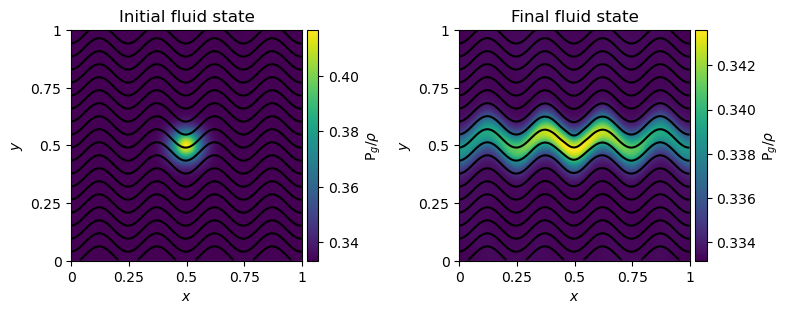

In [4]:
import pyharm
import matplotlib
import numpy as np
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

# Function to overlay field lines
# Argument must be axes object, dump, and 'nlines' -> a parameter to account for density of field lines
def plotting_bfield_lines(ax, dump, nlines=20):
  B1 = np.squeeze(dump['B1'])
  B2 = np.squeeze(dump['B2'])
  AJ_phi = np.zeros([dump['n1'], dump['n2']])
  for j in range(dump['n2']):
    for i in range(dump['n1']):
      AJ_phi[dump['n1']-1-i,j] = (np.trapz(B2[:i,j], dx=dump['dx1']) - np.trapz(B1[i,:j], dx=dump['dx2']))
  AJ_phi -= AJ_phi.min()
  levels  = np.linspace(0, AJ_phi.max(), nlines)
  ax.contour(np.squeeze(dump['X1']), np.squeeze(dump['X2']), AJ_phi, levels=levels, colors='k')

# Create figure object and grid
fig = plt.figure(figsize=(8,4))
nrows = 1
ncols = 2
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# Load first dump and plot
dump = pyharm.load_dump('') # insert path to first dump
temperature_plot = ax0.pcolormesh(np.squeeze(dump['X1']), np.squeeze(dump['X2']), np.squeeze(dump['Theta']), cmap = 'viridis', shading='gouraud')
plotting_bfield_lines(ax0, dump, nlines=20)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.set_xticks([0,0.25,0.5,0.75,1])
ax0.set_xticklabels([0,0.25,0.5,0.75,1])
ax0.set_yticks([0,0.25,0.5,0.75,1])
ax0.set_yticklabels([0,0.25,0.5,0.75,1])
ax0.set_xlabel('$x$')
ax0.set_ylabel('$y$')
ax0.set_title('Initial fluid state')
ax0.set_aspect('equal')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(temperature_plot, cax=cax)
cbar.set_label('P$_{g}/\\rho$', rotation=90)

# Load final dump and plot
dump = pyharm.load_dump('') # insert path to final dump
temperature_plot = ax1.pcolormesh(np.squeeze(dump['X1']), np.squeeze(dump['X2']), np.squeeze(dump['Theta']), cmap = 'viridis', shading='gouraud')
plotting_bfield_lines(ax1, dump, nlines=20)
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xticks([0,0.25,0.5,0.75,1])
ax1.set_xticklabels([0,0.25,0.5,0.75,1])
ax1.set_yticks([0,0.25,0.5,0.75,1])
ax1.set_yticklabels([0,0.25,0.5,0.75,1])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Final fluid state')
ax1.set_aspect('equal')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(temperature_plot, cax=cax)
cbar.set_label('P$_{g}/\\rho$', rotation=90)

plt.tight_layout()
plt.show()

Due to temperature gradients in the system, there is thermal conduction along the magnetic field lines.

Now that we've run a couple of problems, let us go over one of the packages in KHARMA...

### Problem 3: 2D black hole accretion

The final problem we'll run is a 2D GRMHD simulation of black hole accretion. As before, create a new directory `SIMULATION_DIR` to stage the output and copy the parameter file `sane2d.par` to the directory.
```
cd SIMULATION_DIR
cp PATH_TO_KHARMA_SOURCE/scripts/tutorial/batch/rusty_gpu.sb ./
cp PATH_TO_KHARMA_SOURCE/scripts/tutorial/parfiles/sane2d.par ./
```

This will take ~2 hours to run to $\sim3000 GM/c^{3}$. Modify the job job run time accordingly:

```
sbatch -t 02:00:00 rusty_gpu.sb -i sane2d.par
```

Let's go over some of the additional blocks of parameters present in black hole accretion simulations...

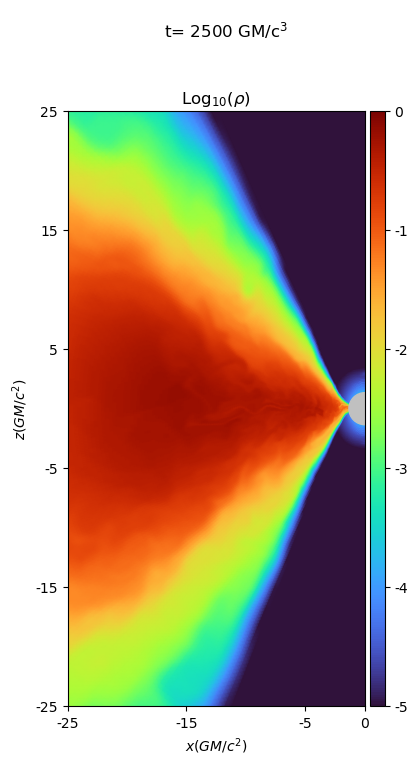

In [5]:
import pyharm
import matplotlib
import numpy as np
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

# Take poloidal slice of 2D array
def xz_slice(var, dump, patch_pole=False):
  xz_var = np.zeros((dump['n1'], dump['n2']))
  for i in range(dump['n1']):
    xz_var[i,:] = var[dump['n1']-1-i,:]
  if patch_pole:
    xz_var[:,0] = xz_var[:,-1] = 0
  return xz_var

# load dump
dump = pyharm.load_dump('') # insert path to dump

x_slice   = xz_slice(np.squeeze(dump['x']), dump, patch_pole=True)
z_slice   = xz_slice(np.squeeze(dump['z']), dump)
rho_slice = xz_slice(np.squeeze(dump['rho']), dump)

fig = plt.figure(figsize=(4,8))
nrows = 2
ncols = 1
heights = [1,16]
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, height_ratios=heights, figure=fig)

t = "{:d}".format(int(dump['t']))

ax0 = fig.add_subplot(gs[0,0])
ax0.annotate('t= '+str(t)+' GM/c$^3$', xy=(0.5,0.5), xycoords='axes fraction', va='center', ha='center', fontsize='large')
ax0.axis("off")

ax1 = fig.add_subplot(gs[1,0])
rho_plot = ax1.pcolormesh(x_slice, z_slice, np.log10(rho_slice), cmap = 'turbo', vmin=-5, vmax=0, shading='gouraud')
ax1.set_xlim(-25,0)
ax1.set_ylim(-25,25)
ax1.set_xticks([-25,-15,-5,0])
ax1.set_xticklabels([-25,-15,-5,0])
ax1.set_yticks([-25,-15,-5,5,15,25])
ax1.set_yticklabels([-25,-15,-5,5,15,25])
ax1.set_xlabel('$x (GM/c^2)$')
ax1.set_ylabel('$z (GM/c^2)$')
ax1.set_title('Log$_{10}(\\rho)$')
circle = plt.Circle((0,0), dump['r_eh'], color='silver')
ax1.add_artist(circle)
ax1.set_aspect('equal')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(rho_plot, cax=cax, ticks = [0, -1, -2, -3, -4, -5])
cbar.ax.set_yticklabels([0, -1, -2, -3, -4, -5])
plt.tight_layout()
plt.show()